In [94]:
#Alen Kuruppan
#Ravel Larose 
#ISTE 612 Project - Brooklyn 99 NLP

<div id=1> <h2>  1. Importing packages and libraries  </h2> </div> 

In [1]:

import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch



# Any results you write to the current directory are saved as output.

**Below is a helper Function which generates random colors which can be used to give different colors to your plots.Feel free to use it**

In [2]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

<div id=2> <h2> 2. Reading the Data  </h2></div> 

In [3]:
import pandas as pd
import numpy as np
train=pd.read_csv('tweets.csv',encoding='utf-8')

In [4]:
train

User                                            Content  \
0          TheDailyMeg  I'm about to tweet a lot about the   #seasonfi...   
1             _cgrants  A double dose of   is exactly what I need afte...   
2               HamJoh    Here it is. Last date with Nine-Nine. Will b...   
3         amysaintiago                                 it's time ladiez     
4      stillfeelaawake                    IT'S TIME!!!   Season Finale!!!   
...                ...                                                ...   
10597         pecavati  I've just watched episode S06 | E02 of Brookly...   
10598  Tristan08555780  "I don't know how batman does it, it is super ...   
10599         pecavati  I've just watched episode S06 | E01 of Brookly...   
10600  Tristan08555780  Watching Brooklyn Nine-Nine for the first time...   
10601            pecav                                                NaN   

           Date      Time  
0      23/05/17  23:59:47  
1      23/05/17  23:59:36  
2      23/05/17  23:59:26  
3      23/05/17  23:59:25  
4      23/05/17  23:57:32  
...         ...       ...  
10597  22/05/22  22:32:02  
10598  22/05/22  22:26:07  
10599  22/05/22  22:07:33  
10600  22/05/22  21:53:29  
10601       NaN       NaN  

[10602 rows x 4 columns]

In [5]:
print(train.shape)


(10602, 4)


So We have 27486 tweets in the train set and 3535 tweets in the test set

In [6]:
train.describe()

User                                            Content  \
count           10602                                              10601   
unique           3362                                               8857   
top     nbcbrooklyn99  I unlocked an exclusive   clip using #Brooklyn...   
freq              651                                                112   

            Date     Time  
count      10601    10601  
unique        72     9385  
top     10/05/17  3:05:03  
freq        1254        5

In [7]:
train.isna().sum()

User       0
Content    1
Date       1
Time       1
dtype: int64

Geo column has all values as nulls, hashtags have lot of null values, mentions also have lot of null values.

<div id=3> <h2> 3. Handling null values </h2> </div>

In [8]:
train['User'].unique()

array(['TheDailyMeg', '_cgrants', 'HamJoh', ..., 'RMufc20',
       'claudiastrater', 'pecav'], dtype=object)

<div id=4> <h2> 4. EDA  </h2></div>

In [9]:
train.head()

User                                            Content  \
0      TheDailyMeg  I'm about to tweet a lot about the   #seasonfi...   
1         _cgrants  A double dose of   is exactly what I need afte...   
2           HamJoh    Here it is. Last date with Nine-Nine. Will b...   
3     amysaintiago                                 it's time ladiez     
4  stillfeelaawake                    IT'S TIME!!!   Season Finale!!!   

       Date      Time  
0  23/05/17  23:59:47  
1  23/05/17  23:59:36  
2  23/05/17  23:59:26  
3  23/05/17  23:59:25  
4  23/05/17  23:57:32

Lets look at the distribution of reviews in the train set

<div id=5> <h2>5. Cleaning the data </h2> </div>

Let's first clean the data, remove stopwords etc and perform basic pre-processing

**Removing weird spaces**

In [10]:
def remove_spaces(Content):
    Conetent=Content.strip()
    Content=Content.split()
    return ' '.join(Content)
    

<b> Spelling Correction </b>

In [11]:
def edits1(word):
    letters='abcdefghijklmnopqrstuvwxyz'
    splits=[(word[:i], word[i:]) for i in range(len(word)+1)]
    deletes=[L+R[1:] for L,R in splits if R]
    transposes=[L+R[1] +R[0] + R[2:] for L,R in splits if len(R)>1]
    replaces = [L+c+R[1:] for L,R in splits if R for c in letters]
    inserts = [L+c+ R for L,R in splits for c in letters]
    return set(deletes+transposes+replaces+inserts)
def edits2(word):
    return(e2 for e1 in edits1(word) for e2 in edits1(e1))
            

<b> Contraction </b>

In [12]:
contraction = {'cause':'because',
              'aint': 'am not',
              'aren\'t': 'are not'}

def mapping_replacer(x,dic):
    for words in dic.keys():
        if ' ' + words + ' ' in x:
            x=x.replace(' '+ words +' ' ,' '+dic[words]+' ' )
    return x

    

<b> Stemming, lemmetisation and tokenisation
</b>

In [13]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

nltk.LancasterStemmer
ls = LancasterStemmer()
lem = WordNetLemmatizer()
def lexicon_normalization(Content):
    words = word_tokenize(Content) 
    
    
    # 1- Stemming
    words_stem = [ls.stem(w) for w in words]
    
    # 2- Lemmatization
    words_lem = [lem.lemmatize(w) for w in words_stem]
    return words_lem

    

[nltk_data] Downloading package punkt to /Users/Alen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<b> Handling emojis </b>

In [14]:
import emoji
import re 
#from emot.emo_unicode import UNICODE_EMO
def convert_emojis(Content):
    for emot in emoji.UNICODE_EMOJI:
        Content = re.sub(r'('+emot+')', "_".join(emoji.UNICODE_EMOJI[emot].replace(",","").replace(":","").split()), Content)
    return Content

<b>Removing links, brackets, numbers, punctuations etc. </b>


In [15]:
def clean_text(Content):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    Content = str(Content).lower()
    Content = re.sub('\[.*?\]', '', Content)
    Content = re.sub('https?://\S+|www\.\S+', '', Content)
    Content = re.sub('<.*?>+', '', Content)
    Content = re.sub('[%s]' % re.escape(string.punctuation), '', Content)
    Content = re.sub('\n', '', Content)
    Content = re.sub('\w*\d\w*', '', Content)
    Content = re.sub('\'','', Content)
    
    return Content

<b> Handling stopwords </b>

In [16]:
from collections import Counter
def remove_stopword(Content):
    stop_words = stopwords.words('english')
    stopwords_dict = Counter(stop_words)
    Content = ' '.join([word for word in Content.split() if word not in stopwords_dict])
    return Content

<b> Tokenisation </b>

In [17]:
def tokenise(Content):
    words = word_tokenize(Content) 
    return words


<div id = 6> <h2> 6. Applying data cleaning steps to data </h2> </div>

Cleaning Regex Expressions from data

In [18]:
import re
train['Content'] = train['Content'].map(lambda x: re.sub(r'\W+', ' ', str(x)))
train['Content'] = train['Content'].replace(r'\W+', ' ', regex=True)


In [19]:
train.head()

User                                            Content  \
0      TheDailyMeg  I m about to tweet a lot about the seasonfinal...   
1         _cgrants  A double dose of is exactly what I need after ...   
2           HamJoh   Here it is Last date with Nine Nine Will be l...   
3     amysaintiago                                  it s time ladiez    
4  stillfeelaawake                           IT S TIME Season Finale    

       Date      Time  
0  23/05/17  23:59:47  
1  23/05/17  23:59:36  
2  23/05/17  23:59:26  
3  23/05/17  23:59:25  
4  23/05/17  23:57:32

In [20]:
train['Content']=train['Content'].apply(lambda x: mapping_replacer(str(x), contraction))

In [21]:
train['Content'] = train['Content'].apply(lambda x:clean_text(str(x)))

In [22]:
train['Content']=train['Content'].apply(lambda x: remove_stopword(str(x)))


In [23]:
pip install wordnet

Note: you may need to restart the kernel to use updated packages.


In [24]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/Alen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
train['Content']=train['Content'].apply(lambda x: lexicon_normalization(str(x)))

In [26]:
train.head()

User                                          Content      Date  \
0      TheDailyMeg              [tweet, lot, seasonfin, get, ready]  23/05/17   
1         _cgrants          [doubl, do, exact, nee, sad, last, day]  23/05/17   
2           HamJoh  [last, dat, nin, nin, le, sad, season, confirm]  23/05/17   
3     amysaintiago                                    [tim, ladiez]  23/05/17   
4  stillfeelaawake                               [tim, season, fin]  23/05/17   

       Time  
0  23:59:47  
1  23:59:36  
2  23:59:26  
3  23:59:25  
4  23:57:32

<div id=7><h2>7. Finding the most Common words in our Text </h2></div>

In [27]:
top = Counter([item for sublist in train['Content'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [28]:
blacklist = ['http','https','www','com', 'ev','u','ly','pic','would']

def remove_words(text):
    text = [i for i in text if (i not in blacklist)]
    return text

In [29]:
#train['content']=remove_words(train['content'])

train['Content'] = train['Content'].apply(lambda x: [i for i in x if i not in blacklist])

In [30]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [31]:
top = Counter([item for sublist in train['Content'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

In [32]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

<div id = 8><h2>8. Finding Most common words Sentiments Wise</h2></div>

Let's look at the most common words in different sentiments

<div id=8.1><h3>8.1 Finding the tweet sentiment </div></h3>

In [33]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

from textblob import TextBlob

def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(tweet) 
    
    # set sentiment 
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

In [34]:
train['sentiment']=train['Content'].apply(lambda x: get_tweet_sentiment(' '.join(x)))

In [35]:
train.head()

User                                          Content      Date  \
0      TheDailyMeg              [tweet, lot, seasonfin, get, ready]  23/05/17   
1         _cgrants          [doubl, do, exact, nee, sad, last, day]  23/05/17   
2           HamJoh  [last, dat, nin, nin, le, sad, season, confirm]  23/05/17   
3     amysaintiago                                    [tim, ladiez]  23/05/17   
4  stillfeelaawake                               [tim, season, fin]  23/05/17   

       Time sentiment  
0  23:59:47  positive  
1  23:59:36  negative  
2  23:59:26  negative  
3  23:59:25   neutral  
4  23:57:32   neutral

In [36]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

<b> Overall tweet sentiment </b>

In [37]:
print('Number of tweets with positive sentiment', Positive_sent['sentiment'].count())
print('Number of tweets with negative sentiment', Negative_sent['sentiment'].count())
print('Number of tweets with neutral sentiment', Neutral_sent['sentiment'].count())


Number of tweets with positive sentiment 2505
Number of tweets with negative sentiment 902
Number of tweets with neutral sentiment 7195


<b><i>So we see that overall the tweets are neutral in nature, followed by positive sentiment for the time in which they are analysed.</i></b>

<div id=8.2><h3>8.2 Finding common words for positive sentiment tweets</div></h3>

In [38]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['Content'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

Since we have words like 's', 'gre' which do not really mean anything, we will remove them and find the most common words

In [39]:
import numpy as np
top = Counter([item for sublist in Positive_sent['Content'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(23))
temp_positive.columns = ['Common_words','count']
temp_positive['Common_words'] = temp_positive['Common_words'].map(lambda x: re.sub(r'\W+', '', x))
temp_positive['Common_words'] = temp_positive['Common_words'].replace(r'\W+', '', regex=True)
temp_positive['Common_words'] = temp_positive['Common_words'].apply(lambda x:remove_spaces(x))
temp_positive=temp_positive[~temp_positive['Common_words'].isin(['s','gre','“',' * '])] #new line removing meaningless words
mask1 = temp_positive.Common_words.str.contains('[a-zA-Z]')
mask2 = temp_positive.Common_words.notna()
temp_positive = temp_positive[mask1 | mask2]
temp_positive.Common_words =  temp_positive.Common_words.str.replace(r"\s+", "").replace("", np.NaN)
temp_positive=temp_positive.dropna()


temp_positive.style.background_gradient(cmap='Greens')


/var/folders/8z/dtx2yrr16tgbhmb3t105m6sm0000gn/T/ipykernel_60406/80192688.py:12: FutureWarning:

The default value of regex will change from True to False in a future version.



In [40]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Words in Positive Sentiment tweets', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

<div id=8.3><h3>8.3 Finding the common words for negative sentiment tweets </div></h3>

In [41]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['Content'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

In [42]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['Content'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(22))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']

#Data cleaning
temp_negative['Common_words'] = temp_negative['Common_words'].map(lambda x: re.sub(r'\W+', '', x))
temp_negative['Common_words'] = temp_negative['Common_words'].replace(r'\W+', '', regex=True)
temp_negative=temp_negative[~temp_negative['Common_words'].isin(['s','t'])] #new line removing meaningless words from above
#mask1 = temp_negative.Common_words.str.contains('[a-zA-Z]')
#mask2 = temp_negative.Common_words.notna()
#temp_negative = temp_negative[mask1 | mask2]

temp_negative.Common_words =  temp_negative.Common_words.replace("", np.nan)
temp_negative = temp_negative.dropna(subset=['Common_words'])

temp_negative.style.background_gradient(cmap='Reds')

In [43]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Words in Negative Tweets')
fig.show()

<div id=8.4><h3>8.4 Finding the common words for neutral sentiment tweets </div></h3>

In [44]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['Content'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

In [45]:

top = Counter([item for sublist in Neutral_sent['Content'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']

#Data cleaning
temp_neutral['Common_words'] = temp_neutral['Common_words'].map(lambda x: re.sub(r'\W+', '', x))
temp_neutral['Common_words'] = temp_neutral['Common_words'].replace(r'\W+', '', regex=True)
temp_neutral=temp_neutral[~temp_neutral['Common_words'].isin(['s'])] #new line removing meaningless words from above

temp_neutral.Common_words =  temp_neutral.Common_words.replace("", np.nan)
temp_neutral = temp_neutral.dropna(subset=['Common_words'])

temp_neutral.style.background_gradient(cmap='Reds')

In [46]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [47]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

<div id=9><h2>9. Number of Unique Words in tweets of each type of sentiment </h2> </div>

We will look at number of unique words in each type of tweet with different sentiments:
* Positive
* Negative
* Neutral

In [48]:
raw_text = [word for word_list in train['Content'] for word in word_list]

In [49]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['Content']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['Content']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

  <div id=9.1><h2>9.1. Number of unique words in tweets with positive sentiment  </h2> </div>

In [50]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


In [51]:
Unique_Positive

words  count
0    perfect    101
1        win     45
2      proud     35
3        hot     30
4         ok     27
5      sweet     24
6      smart     20
7       fast     18
8        fit     16
9     strong     14
10  greatest     10
11      york     10
12      cont     10
13     light      9
14       joy      9
15       gay      8
16      calm      8
17     young      8
18      audy      7
19    foxnow      7

In [52]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Words in Positive sentiment tweets')
fig.show()

In [56]:
pip install palettable.colorbrewer.qualitative



SyntaxError: invalid syntax (2784248904.py, line 1)

In [57]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique words in Positive sentiment tweets')
plt.show()

  <div id=9.2><h2>9.2. Number of unique words in tweets with negative sentiment  </h2> </div>

In [58]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


In [56]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique words in Negative sentiment tweets')
plt.show()

  <div id=9.3><h2>9.3. Number of unique words in tweets with neutral sentiments  </h2> </div>

In [59]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


Since the count for positive, negative and neutral sentiments is so less, there is no use of creating word clouds with unique words. So we will create a wordcloud with all the words combined.

In [65]:
#Data cleaning
Unique_Neutral= words_unique('neutral', 14, raw_text)
Unique_Neutral['words'] = Unique_Neutral['words'].map(lambda x: re.sub(r'\W+', '', x))
Unique_Neutral['words'] = Unique_Neutral['words'].replace(r'\W+', '', regex=True)
#Unique_Neutral['words']=Unique_Neutral[~Unique_Neutral['words'].isin(['به','را','ایران','و'])] #new line removing meaningless words from above

Unique_Neutral['words'] =  Unique_Neutral['words'].replace("", np.nan)
Unique_Neutral= Unique_Neutral.dropna(subset=['words'])

Unique_Neutral.style.background_gradient(cmap='Reds')

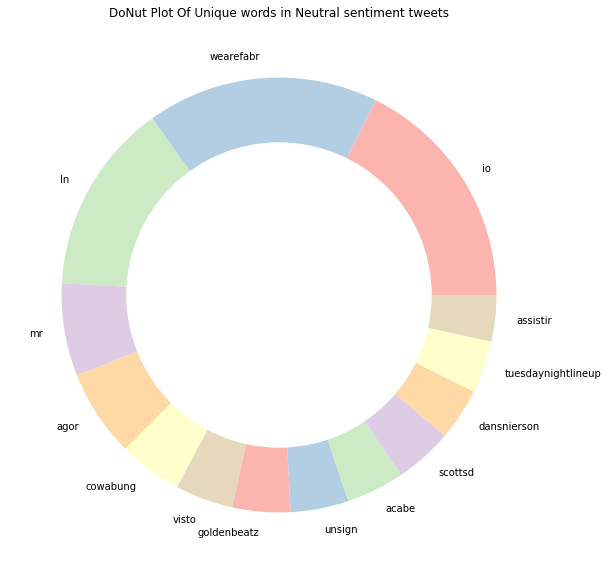

In [66]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique words in Neutral sentiment tweets')
plt.show()

**By Looking at the Unique Words of each sentiment,we now have much more clarity about the data**

We shall now proceed to create word clouds, but we shall make word cloud of all words and not just existing words since unique words are very less in number for many sentiments (10,7,9 etc.) , so an effective word cloud can be only made by considering all the words in different sentiment tweets

<div id=10><h2>10. WordClouds</h2> </div>


We will be building three types of wordclouds:

* WordCloud of Neutral Tweets
* WordCloud of Positive Tweets
* WordCloud of Negative Tweets

In [78]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [86]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    
    wordcloud = WordCloud(background_color=color,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '/Users/Alen/Downloads/b99/b99_wordcloud'

<div id=10><h2>10.1. WordCloud for neutral sentiment</h2> </div>

In [87]:
Neutral_sent

User                                            Content  \
3         amysaintiago                                      [tim, ladiez]   
4      stillfeelaawake                                 [tim, season, fin]   
5         JMRamos1701D  [philippin, tomorrow, divaphilippin, terrycrew...   
6         JMRamos1701D  [amp, canad, season, fin, start, mogoodwin, do...   
9               TVView  [tonight, fox, alway, fre, tv, list, tvview, a...   
...                ...                                                ...   
10594    Steph_11and78  [jak, fig, gin, on, tattl, let, tak, blam, per...   
10596    Steph_11and78                [peraltiago, gin, ar, school, reun]   
10597         pecavati  [watch, episod, brooklyn, nin, nin, tvtime, r,...   
10599         pecavati  [watch, episod, brooklyn, nin, nin, tvtime, r,...   
10601            pecav                                              [nan]   

           Date      Time sentiment  
3      23/05/17  23:59:25   neutral  
4      23/05/17  23:57:32   neutral  
5      23/05/17  23:53:40   neutral  
6      23/05/17  23:53:36   neutral  
9      23/05/17  23:44:10   neutral  
...         ...       ...       ...  
10594  22/05/22  22:53:05   neutral  
10596  22/05/22  22:44:38   neutral  
10597  22/05/22  22:32:02   neutral  
10599  22/05/22  22:07:33   neutral  
10601       NaN       NaN   neutral  

[7195 rows x 5 columns]

In [89]:
#pos_mask = np.array(Image.open('/Users/Alen/Downloads/b99/b99_wordcloud/'))
plot_wordcloud(Neutral_sent.Content,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

<div id=10.2><h2>10.2 WordCloud for positive sentiment</h2> </div>


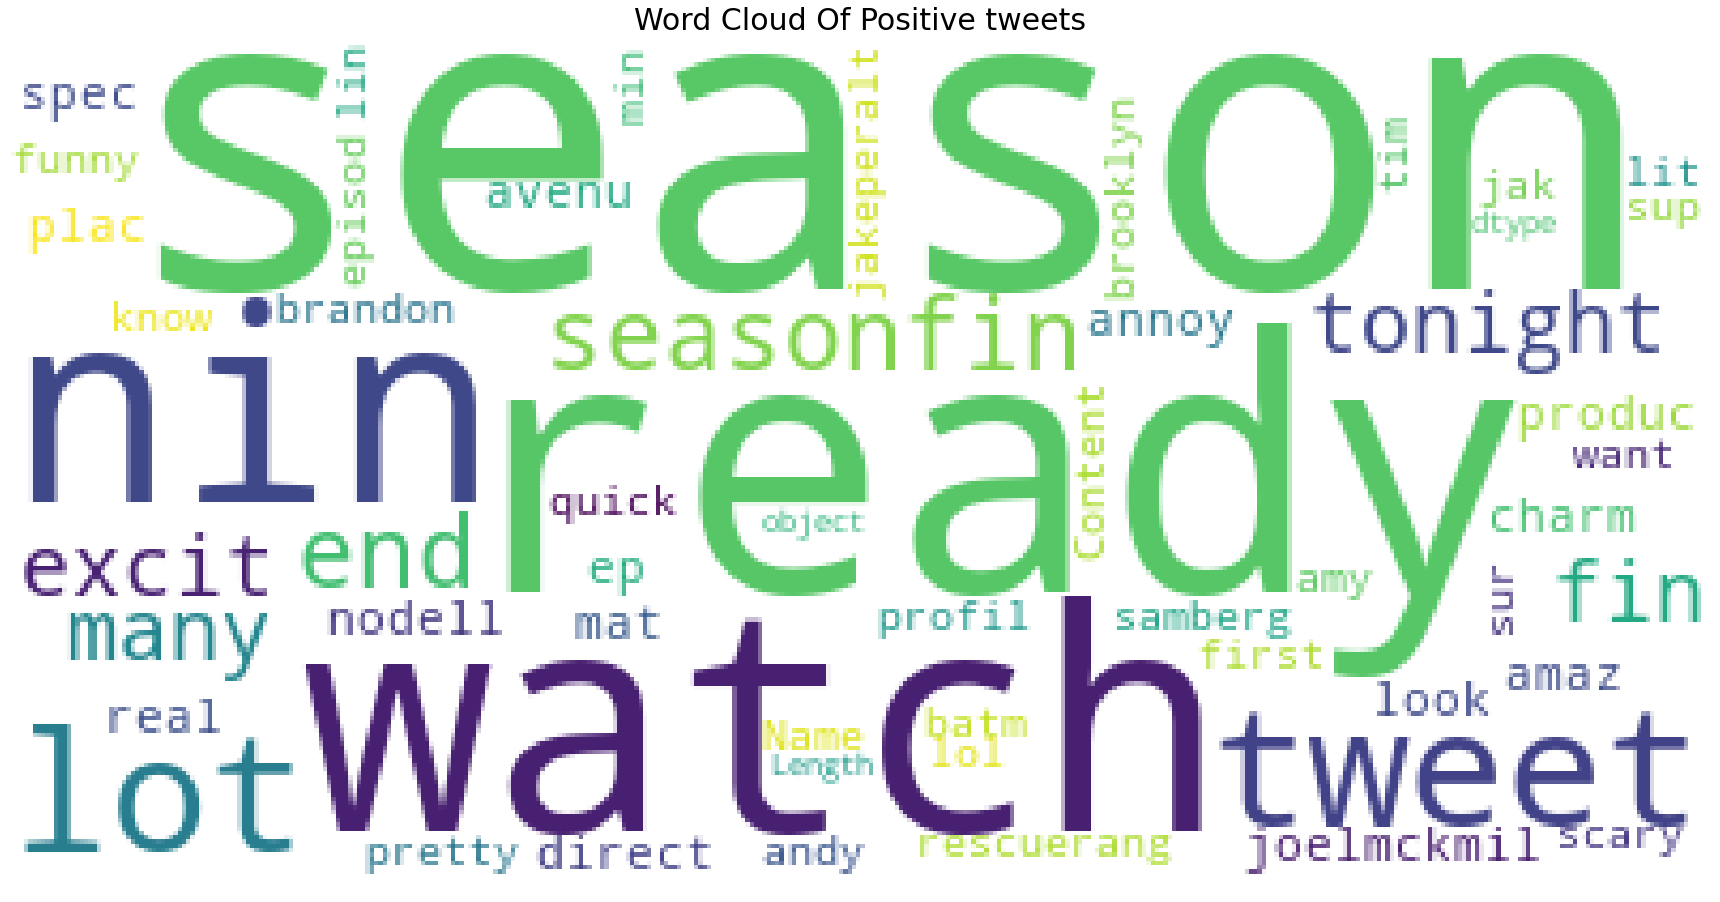

In [90]:
plot_wordcloud(Positive_sent.Content,title="Word Cloud Of Positive tweets",title_size=30)

<div id=10.3><h2>10.3 WordCloud for Tweets with negative sentiment</h2> </div>

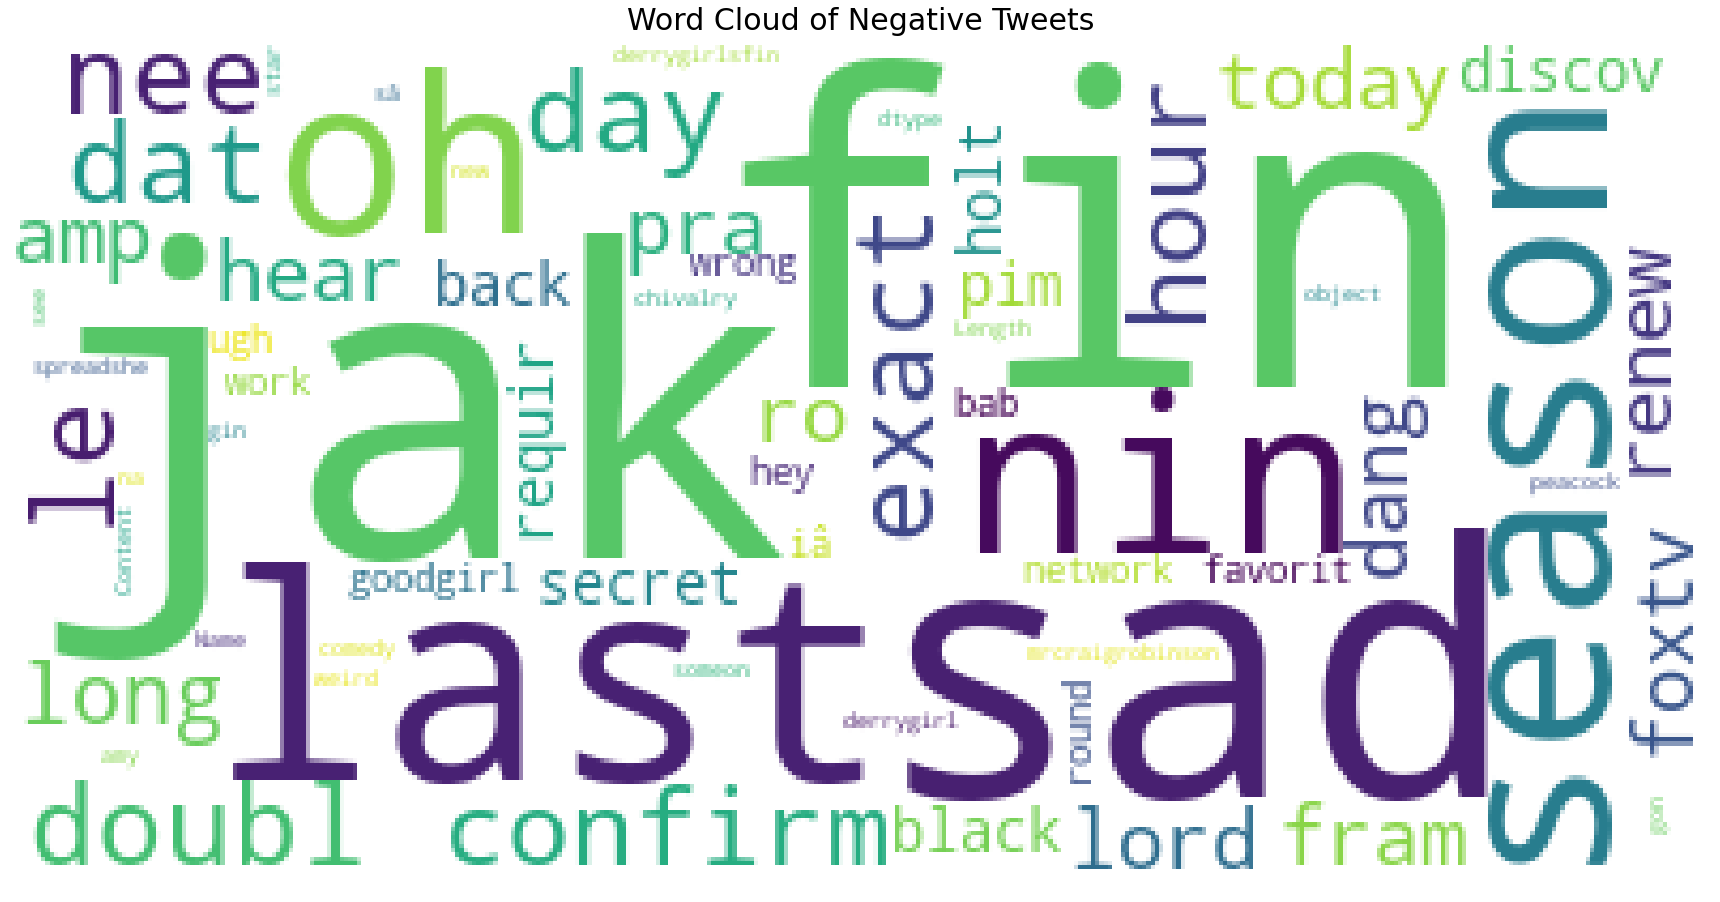

In [91]:
plot_wordcloud(Negative_sent.Content,title="Word Cloud of Negative Tweets",color='white',title_size=30)